OK, now that we've run our first simulations, let's add in a bit more complexity.

Last time we did this:
1. Turn on hoomd-blue, a simulation engine that works nicely in python
1. Load in a configuration of randomly-packed spheres that has been created for us
1. Define Lennard-Jones interaction rules and an NVT ensemble
    1. Bonus: We're going to set the initial velocities, too
1. Step forward 10000 steps.
1. Visualize the last snapshot.


This time we're going to :
1. Turn on hoomd-blue, a simulation engine that works nicely in python
1. Load in a configuration of randomly-packed spheres that has been created for us
1. Define Lennard-Jones interaction rules and an NVT ensemble
    1. Bonus: We're going to set the initial velocities, too
1. __NEW: Set up a logger that will save simulation information we can use.__
1. Step forward 10000 steps.
1. __NEW: ~~Visualize the last snapshot.~~__
1. __NEW: Plot kinetic temperature__



In [1]:
import hoomd
import gsd.hoomd

In [2]:
#This is steps 1-3 from before
# Attach to CPU and create simulation
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu,seed=0)
sim.create_state_from_gsd(filename='random.gsd') #N and V are set here

#Potential and integrator setup
integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer = 0.4)
lj_potential = hoomd.md.pair.LJ(nlist=cell)
lj_potential.params[('A','A')] = dict(epsilon=1,sigma=1)
lj_potential.r_cut[('A','A')]=2.5
nvt = hoomd.md.methods.NVT(kT=1.5,filter=hoomd.filter.All(),tau=1.)
integrator.forces.append(lj_potential)
integrator.methods.append(nvt)
sim.operations.integrator = integrator

# Set the simulation state 
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)



In [3]:
#NEW logger
# We need to define which atoms participate in logging, what's logged, and where to store that info.
selection = hoomd.filter.All() # "which atoms"
logger = hoomd.logging.Logger() # will be used for "what's logged"
trajfile = 'traj2.gsd'
writer = hoomd.write.GSD(filename=trajfile, # "where to store"
                             trigger=hoomd.trigger.Periodic(100), #when to store
                             mode='wb',
                             filter=selection) #filter=hoomd.filter.Null() to only store log

thermo_props = hoomd.md.compute.ThermodynamicQuantities(filter=selection) # What to store
logger.add(thermo_props)
logger.add(sim,quantities=['timestep','walltime','tps'])
writer.log = logger #need to tell our write which logger to use when it's logging info

sim.operations.computes.append(thermo_props) #tell our simulation to *compute* the thermo properties
sim.operations.writers.append(writer) # tell our simulation which writer(s) to use


In [4]:
# Run  the simulation  (a few seconds)
sim.run(1e4)

In [5]:
# Use the log to analyze properties
traj = gsd.hoomd.open(trajfile,'rb')
traj[0].log #let's see what things we can access in the log

{'md/compute/ThermodynamicQuantities/kinetic_temperature': array([1.46157603]),
 'md/compute/ThermodynamicQuantities/pressure': array([0.40569009]),
 'md/compute/ThermodynamicQuantities/pressure_tensor': array([ 0.24328429, -0.04646473,  0.01355323,  0.38049974, -0.07764049,
         0.59328623]),
 'md/compute/ThermodynamicQuantities/kinetic_energy': array([559.05283108]),
 'md/compute/ThermodynamicQuantities/translational_kinetic_energy': array([559.05283108]),
 'md/compute/ThermodynamicQuantities/rotational_kinetic_energy': array([0.]),
 'md/compute/ThermodynamicQuantities/potential_energy': array([-534.12313298]),
 'md/compute/ThermodynamicQuantities/degrees_of_freedom': array([765.]),
 'md/compute/ThermodynamicQuantities/translational_degrees_of_freedom': array([765.]),
 'md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom': array([0.]),
 'md/compute/ThermodynamicQuantities/num_particles': array([256]),
 'md/compute/ThermodynamicQuantities/volume': array([753.57109477]

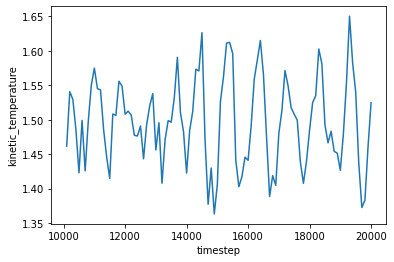

In [7]:
from day1_utils import arrays_from_gsd
import matplotlib.pyplot as plt
x = 'timestep'
y = 'kinetic_temperature'
[xd,yd] = arrays_from_gsd(trajfile,keys=[x,y])
plt.plot(xd,yd)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

Activities:
* Compare kinetic temperature with setpoint temperature
* Check kinetic temperature right for n_dof
* Change NVT to NPT
* Vary T, P to change density
* Discussion of units
* Discussion of various file formats